In [95]:
import pandas as pd
import os
import numpy as np
import scipy as sp
#
import gensim
from smart_open import smart_open
import multiprocessing

In [51]:
%matplotlib inline

Steps to be performed:

0) import manually annotated set

1) for final chosen annotations - check self-consistency of doubles

1.1) if all self cosistent, select unique set. else make note of inconsistent annotations and use first occurance value

2) import corpus, look-up corpus, frozen model and reinferred model vectors

3) select and construct reduced corpus/lookup-corpus from annotated set, select corresponding reinferred vectors

4) implement (interactive) selection on this for seed fragments:
    issues: 
    
    - which seed fragment
            
    - how far should expansion go

5) explore and quantify behaviour of returned ground truth as function of cosine distance

## 0) Import annotated ground truth

In [4]:
groundTruthFile='Manual_annotation_TOTAAL_door_Jeroen_en_Susan.xlsx'
groundTruthFileSheet='Resultaat Manuele Annotatie'

In [5]:
groundTruth = pd.read_excel(groundTruthFile, sheet_name=groundTruthFileSheet)

In [6]:
#groundTruth['Titel']


In [7]:
type(groundTruth)

pandas.core.frame.DataFrame

## 1) Check duplicates for self-consistency

In [8]:
# show duplicate entries to check whether EINDOORDEEL is consistent. It is, so duplicate can be dropped.
pd.concat(g for _, g in groundTruth.groupby("Titel") if len(g) > 1)


,Herkomst,Titel,Tekst,JEROEN_janee,JEROEN_OPM,SUSAN_janee,SUSAN_OPM,VERGELIJKING,CONCLUSIE,EINDOORDEEL_janee
614,manual_annotation_sample_seed1117,GV_AVA_doven_04_conversation_clipped_150_parag...,"Maar na de oorlog moest ik naar Amsterdam , en...",nee,NaN,nee,NaN,zelfde,NaN,nee
778,manual_annotation_sample_seed1118,GV_AVA_doven_04_conversation_clipped_150_parag...,"Maar na de oorlog moest ik naar Amsterdam , en...",nee,NaN,nee,NaN,zelfde,NaN,nee
564,manual_annotation_sample_seed1116,GV_AVA_doven_05_conversation_clipped_150_parag...,Mijn ouders en de school dat was zo' n tweehon...,nee,NaN,nee,NaN,zelfde,NaN,nee
859,manual_annotation_sample_seed1119,GV_AVA_doven_05_conversation_clipped_150_parag...,Mijn ouders en de school dat was zo' n tweehon...,nee,Deze tekst heb ik al eerder gezien…,nee,NaN,zelfde,NaN,nee
696,manual_annotation_sample_seed1117,GV_DeJager_ReisvandeRazzia_interview_Breda_con...,"Dus je weet hoe de Jordaners hË , dus dat was ...",ja,NaN,nee,NaN,ANDERS,Onheil,ja
737,manual_annotation_sample_seed1118,GV_DeJager_ReisvandeRazzia_interview_Breda_con...,"Dus je weet hoe de Jordaners hË , dus dat was ...",ja,Deze tekst zat ook in de voorgaande set,nee,NaN,ANDERS,Onheil,ja
315,manual_annotation_sample_seed1114,GV_DeJager_ReisvandeRazzia_interview_Gerard_Pa...,"Het zit , ja , dat is het . Ja , daar staat di...",ja,NaN,nee,NaN,ANDERS,NaN,nee
415,manual_annotation_sample_seed1115,GV_DeJager_ReisvandeRazzia_interview_Gerard_Pa...,"Het zit , ja , dat is het . Ja , daar staat di...",ja,Dit fragment heb ik al eens eerder gezien,nee,NaN,ANDERS,Het gaat niet over het bombardement zelf,nee
45,manual_annotation_sample_seed1111,GV_DeJager_ReisvandeRazzia_interview_Zuijdweg_...,Dat je niet wist waar je kruipen moest ! Waar ...,ja,NaN,nee,twiijfel,ANDERS,Conclusie: WEL als geweld benoemen. Dit is een...,ja
121,manual_annotation_sample_seed1112,GV_DeJager_ReisvandeRazzia_interview_Zuijdweg_...,Dat je niet wist waar je kruipen moest ! Waar ...,ja,Deze snippet zat ook in de eerste set!,ja,NaN,zelfde,NaN,ja


In [9]:
groundTruth.drop_duplicates(['Titel'],keep='first', inplace=True)
groundTruth.reset_index(drop=True,inplace=True)
groundTruth['Titel'][121]


'GV_Schiedam_gastgezin2_07_conversation_clipped_150_paragraph_468-477_text'

In [10]:
len(groundTruth)

986

## 2) Import corpus and reinferred vectors

The following are routines to instantiate the corpus, this should be moved to a separate utilities module

In [11]:
stopwordsFile = '/Users/eslt0101/Projects/EviDENce/ML/stopwords-nl-stopwords-iso_expanded_gensim_processed.txt'
corpus_dir = '/Users/eslt0101/Data/eScience/EviDENce/Data/NR-Teksts/EviDENce_NR_output_clean/TargetSize150'
corpus_token_file = 'GV_corpus_text_para_clean.txt'
corpus_text_file = 'GV_corpus_text_para_clean.txt'
corpus_filenames_file = 'GV_corpus_text_para_clean_filenames.txt'

full_ctokf = os.path.join(corpus_dir,corpus_token_file)
full_ctf = os.path.join(corpus_dir,corpus_text_file)
full_cff = os.path.join(corpus_dir,corpus_filenames_file) 

In [12]:
with open(stopwordsFile) as f:
    dutch_stopwords = f.readlines()
    

In [13]:
dutch_stopwords = [w.rstrip() for  w in dutch_stopwords]


In [14]:
def read_corpus(corpus_token_file,labeled=False):
    with smart_open(corpus_token_file,'r') as tf:
        for i,text_line in enumerate(tf):
            if labeled :
                #yield gensim.models.doc2vec.TaggedDocument(gensim.utils.simple_preprocess(text_line), [fn_line.rstrip()])
                yield gensim.models.doc2vec.TaggedDocument([token for token in gensim.utils.simple_preprocess(text_line,deacc=True) if token not in dutch_stopwords], [i])
            else:
                yield [token for token in gensim.utils.simple_preprocess(text_line,deacc=True) if token not in dutch_stopwords]

In [15]:
def read_corpus_lookup(corpus_filenames_file, corpus_token_file) :
    with smart_open(corpus_filenames_file, 'r') as fnf, smart_open(corpus_token_file,'r') as tf:
        i=0
        for (fn_line,tf_line) in zip(fnf,tf):
            yield ([i],[fn_line.rstrip()],[tf_line])
            i+=1

In [16]:
corp = list(read_corpus(full_ctokf,labeled=True))

In [17]:
corp_lookup = list(read_corpus_lookup(full_cff,full_ctokf))

The following loads the frozen trained model

In [18]:
model = gensim.utils.SaveLoad.load('/Users/eslt0101/Projects/EviDENce/ML/model_default_v50_mc2_e30_freeze.d2v')


load the reinferred vectors for the full corpus

In [19]:
reinf_corp_medvec= np.load('/Users/eslt0101/Projects/EviDENce/ML/reinferred_corpus_terms_para_150_medvec.npy')

## 3) construct corpus/vector set limited to ground truth

In [20]:
corp_lookup[0][1]

['05_JKKV_2003_JACQUES_FURTH_conversation_clipped_150_paragraph_104-108_text.txt']

In [21]:
groundTruth['Titel'][0]

'GV_DeJager_ReisvandeRazzia_interview_Welling_conversation_clipped_150_paragraph_248-253_text'

In [22]:
with open(full_cff,'r') as fnf:
    corpFileNames=fnf.readlines()

In [23]:
corpFileNames = [fn.rstrip().split('.')[0] for fn in corpFileNames ]
#corpFileNames = [fn.rstrip() for fn in corpFileNames ]

In [24]:
groundTruth_inCorpusIds =[]
for j in range(len(groundTruth)):
    #print(j, groundTruth['Titel'][j])
    gtTitel = groundTruth['Titel'][j]
    corpusIndex = [i for i,ent in enumerate(corpFileNames) if ent == gtTitel]
    groundTruth_inCorpusIds.append(corpusIndex[0])



In [25]:
#groundTruth_inCorpusIds

In [26]:

gt_corp_lookup = [corp_lookup[i] for i in groundTruth_inCorpusIds]


In [27]:
gt_corp=[corp[i] for i in groundTruth_inCorpusIds]


In [28]:
type(reinf_corp_medvec)

numpy.ndarray

In [29]:
gt_corp_reinf_medvec=reinf_corp_medvec[groundTruth_inCorpusIds]

### Append reinferred vectors to dataframe

In [30]:
series_reinfVec =pd.Series(np.array([]))
for i in range(len(gt_corp_reinf_medvec)):
    series_reinfVec[i] = gt_corp_reinf_medvec[i]
    


In [31]:
groundTruthEx = groundTruth

In [32]:
groundTruthEx.insert(10,'reinfVec',series_reinfVec)

In [33]:
(groundTruthEx['reinfVec'][0])

array([-2.56430432e-01,  2.27939375e-01,  1.74898028e-01, -1.60821885e-01,
       -8.81824270e-02,  1.94943855e-02,  2.41883568e-01,  1.44968554e-01,
       -4.18213367e-01,  7.01342523e-02, -1.14224661e-01, -2.05127247e-01,
        2.00833894e-01, -1.77197434e-01, -4.63656604e-01,  3.95660952e-01,
        3.09191778e-01, -7.80023746e-02, -4.60097857e-04, -3.39287445e-01,
       -1.35585578e-03,  1.85080580e-01, -1.93399340e-01, -2.62891516e-01,
       -4.83413517e-01,  4.78877783e-01,  2.43696617e-02, -5.96371859e-01,
       -3.11087683e-01, -3.90806317e-01,  1.52219348e-01, -4.01255146e-01,
        6.87954336e-01, -4.91834417e-01,  6.13281652e-02,  5.34303468e-02,
       -3.00360933e-01, -1.25750221e-01,  2.99080431e-01,  9.04069655e-02,
       -2.04190202e-02,  1.33660242e-01,  1.02420528e-02,  5.85410986e-02,
        2.02166498e-01, -3.94171465e-03,  1.41045094e-01,  1.30884886e-01,
       -2.02588744e-01, -6.61453581e-03])

In [36]:
type(groundTruthEx['reinfVec'])

pandas.core.series.Series

#### Consider distribution of norms for vectors inferred from coprus. Most w/ 1 < norm < 2

In [68]:
gtNorms=[]
for i in range(len(groundTruthEx)):
    nn=np.linalg.norm(groundTruthEx['reinfVec'][i])
    #print(nn)
    gtNorms.append(nn)


In [48]:
np.array(gtNorms)
gtNorms = pd.Series(gtNorms)

In [69]:
groundTruthEx.insert(11,'vecNorm',gtNorms)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a2caf4e80>,
      dtype=object)

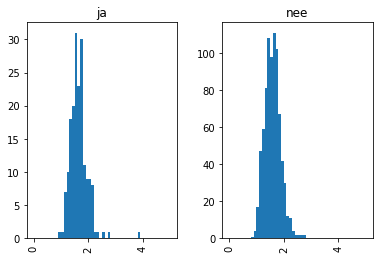

In [76]:
groundTruthEx['vecNorm'].hist(bins=np.arange(0., 5. + 0.1, 0.1),by=groundTruthEx['EINDOORDEEL_janee'])

In [59]:
gtNorms.values.argmax()



320

In [60]:
gtNorms[320]

10.013125173535194

In [67]:
groundTruthEx['EINDOORDEEL_janee'][320]

'nee'

### set up seed fragments and their vectors

In [87]:
seed_fromCorpusExt = "Een razzia . Dus die ... . 'Ja , wat doen we ? ' . En we lopen over het dak , en toen hoorden we vanaf de graansilo , daar stond een luchtafweergeschut , en daar kregen we vuur van . Toen vlogen de kogels om onze oren . Toen zij we als de sodomieter via de schoorsteen , in dekking naar Dordtselaan 98 gevlucht . En daar kwamen we en ja , wat doen we ? Ja , wij gaan niet naar beneden toe . Dus wij gingen niet naar beneden toe . Wij gingen perse niet naar beneden ."
seed_manual = 'hij sloeg er op dat het kapot ging en schoot met zijn geweer. het was verschrikkelijk om aan te zien. ik verstopte me, maar kon het geluid van de explosies niet uit mijn ooren krijgen. Toen het over was ben ik zo snel ik kon gaan rennen.'


In [88]:
seed_fromCorpusExt_processed = [token for token in gensim.utils.simple_preprocess(seed_fromCorpusExt,deacc=True) if token not in dutch_stopwords]
seed_manual_processed = [token for token in gensim.utils.simple_preprocess(seed_manual,deacc=True) if token not in dutch_stopwords]

In [90]:
infVecArr_seed_fromCorpusExt =[]
infVecArr_seed_manual = []

for i in range(100):
    iV_fCE = model.infer_vector(seed_fromCorpusExt_processed)
    iV_m = model.infer_vector(seed_manual_processed)
    
    infVecArr_seed_fromCorpusExt.append(iV_fCE)
    infVecArr_seed_manual.append(iV_m)
    
iV_seed_fromCorpusExt = np.median(np.array(infVecArr_seed_fromCorpusExt), axis=0)
iV_seed_fromCorpusExt_std = np.array(infVecArr_seed_fromCorpusExt).std(axis=0)

iV_seed_manual = np.median(np.array(infVecArr_seed_manual), axis=0)
iV_seed_manual_std = np.array(infVecArr_seed_manual).std(axis=0)



### define distance metrics for vectors

1.) cosine distance

In [91]:
def cosdistance(v1,v2):
    d = np.array([1. - sp.spatial.distance.cosine(v1,v2)])
    return d

In [ ]:
def cosdistance_corp(vec,corpus_vectors):
    cosd_vec_corp =[]
    for i in range (len(corpus_vectors)):
        cd = cosdistance(vec,corpus_vectors[i])
        cosd_vec_corp.append(cd)
    cosd_vec_corp = np.array(cosd_vec_corp).flatten()
    return cosd_vec_corp



In [121]:
iV_seed_fromCorpusExt
#type(groundTruthEx['reinfVec'])

array([-0.01555043, -0.0248374 ,  0.21820459, -0.43900758, -0.16315943,
        0.11548877, -0.28958553,  0.09430026, -0.43780684, -0.02617396,
       -0.08951496, -0.04343161, -0.00807798,  0.00872952, -0.15532914,
        0.14810188,  0.10345003, -0.33083767, -0.01835193, -0.4604437 ,
       -0.14197183,  0.23178986, -0.18801488, -0.00120444, -0.26300782,
        0.16322984,  0.10254323, -0.1795834 , -0.02504658, -0.00248492,
       -0.09794672, -0.08214299,  0.18778518, -0.03405884,  0.04703242,
        0.14858228,  0.02471229, -0.42984113,  0.11954323, -0.09361447,
       -0.16533704,  0.0894762 , -0.06238658, -0.04700024,  0.1894815 ,
       -0.23227441, -0.19673301,  0.02692857,  0.1997892 , -0.19127893],
      dtype=float32)

In [179]:
cosd_seed_fromCorpusExt = cosdistance_corp(iV_seed_fromCorpusExt,groundTruthEx['reinfVec'])

In [180]:
cosd_seed_manual = cosdistance_corp(iV_seed_manual,groundTruthEx['reinfVec'])

In [175]:
cdtest[0:10]

array([ 0.41521772,  0.20700002,  0.30899123,  0.46454745,  0.36123369,
        0.45388755, -0.18668018,  0.33568162,  0.23952087,  0.5326923 ])

In [176]:
cosd_seed_manual[0:10]

array([ 0.41521772,  0.20700002,  0.30899123,  0.46454745,  0.36123369,
        0.45388755, -0.18668018,  0.33568162,  0.23952087,  0.5326923 ])

In [166]:
topN = np.argsort(cosd_seed_fromCorpusExt)[::-1]
topNm = np.argsort(cosd_seed_manual)[::-1]

In [167]:
groundTruthEx.iloc[topNm[0:25],[2,9]]



,Tekst,EINDOORDEEL_janee
622,Dat was een grote ... Daar waren ook barakken ...,nee
11,Dus u ging ervan uit dat er geen goede Nederla...,nee
952,"En toen ben ik naar hem toegegaan , ik zeg ' J...",ja
220,"Je werd wel eens achterna gezeten , maar ze kr...",nee
77,Dat was heel twijfelachtig en in die loop van ...,nee
315,"En toen dachten wij ' nou ' , al die weilanden...",nee
384,"Die Engelsen hebben natuurlijk , die , die Eng...",nee
631,De heer Pieter Braaksma En u bent geboren wann...,nee
360,"Ja , want als het natuurlijk slecht weer was d...",nee
332,Dat heeft me toch heel veel gedaan . En dan ha...,nee


In [169]:
gt_corp_lookup[952]

([1684],
 ['GV_DeJager_ReisvandeRazzia_interview_Ouwendijk_conversation_clipped_150_paragraph_191-198_text.txt'],
 ["En toen ben ik naar hem toegegaan , ik zeg ' Ja , gehört mir , das ist meinem Bruder ' , ' Ja , Sie haben einem Bruder bei der SS ' , en dat hoorden verschillende mensen . Joh Cok , wat is dat , wat heb jij ... en ze wisten al van mijn geheime eetpartijen daar , dus ik zat helemaal verkeerd eigenlijk . Ja ... Om dat overeind te houden allemaal ... maar ik heb inderdaad daar een brief ... dat heb ik niet meer ... dat , nee . Mijn oudste broer Wilhelm Christian die is in 1941 , ook door bezorgde ouders ergens , wat we nooit geweten hebben , op een boerderij in de buurt van Schiedam . Die heb ik nooit meer gesproken , zij het , na de oorlog gelukkig wel . Hetzelfde geldt eigenlijk voor mijn broer , die is in 42. of 43 , dat ben ik even kwijt , die is ook ondergedoken en die is gearresteerd door verraad in de Haarlemmermeer . \n"])

In [120]:
cosdistance(iVseries[None,:], groundTruthEx['reinfVec'])

array([[ 6.30930297e-01, -7.17330424e-01, -9.94883625e-02,
         7.21757633e-01, -3.50156239e-01, -7.98231647e-01,
        -6.23024022e-01, -1.42002858e-02,  6.67956563e-01,
        -4.08176924e-01,  5.24080536e-01, -3.60808297e-02,
        -3.82550116e-01, -2.34134238e-01,  1.50406352e-01,
         7.72290026e-01,  7.88873841e-01,  4.44016891e-01,
        -1.15062272e-01,  8.08696413e-01,  5.83320145e-02,
         4.89314965e-01,  4.84978741e-01,  5.89342253e-01,
         7.27133113e-01,  8.69285318e-01,  2.89678646e-01,
         8.46228526e-01,  5.11000713e-01,  6.77899514e-01,
         2.48394323e-01,  4.64580004e-01,  8.06511708e-01,
         6.61007455e-01,  6.10350462e-01, -2.56599366e-01,
         1.85313093e-01,  2.34244445e-01,  3.58977438e-01,
         6.11764958e-01,  6.92462850e-01,  8.64044236e-02,
        -3.87093415e-01,  5.26261303e-01, -3.36549904e-01,
         7.06941634e-01, -1.74014035e-04,  3.78724638e-01,
        -1.52460488e-01,  7.08242391e-01]])

In [ ]:
cosdist = np.array([1. - sp.spatial.distance.cosine(med_infarr1,rinfc) for rinfc in reinf_corp_medvec])

#cosdist.max()
b=np.argsort(cosdist)[::-1]
print(b[0:25])
print(cosdist[b[0:25]])
len(b)

In [11]:
os.listdir()


['Manual_annotation_TOTAAL_door_Jeroen_en_Susan.xlsx',
 '.ipynb_checkpoints',
 'Import_Ground_Truth.ipynb']

In [3]:
gt = pd.read_excel('ManAtt_JWSH_0001-1000.xlsx',sheet_name='Sheet1')

In [4]:
gt['Titel']


0      GV_DeJager_ReisvandeRazzia_interview_Welling_c...
1      GV_NMKV_Sachsenhausen_01_conversation_clipped_...
2      GV_NIOD_Buchenwald_36_clipped_150_paragraph_55...
3      GV_Overloon_evacuees_08_conversation_clipped_1...
4      GV_Limburg_gastkind_03_conversation_clipped_15...
5      GV_Zigma_koopvaardij_07_conversation_clipped_1...
6      GV_DeJager_ReisvandeRazzia_interview_Smits_con...
7      GV_SiteFilms_Java_05_conversation_clipped_150_...
8      GV_KNMG_medici_11_conversation_clipped_150_par...
9      GV_OVCG_Groningeninoorlogstijd_08_conversation...
10     GV_Verhalis_kloosterzusters_07b_conversation_c...
11     GV_Oogland_KNIL_05_conversation_clipped_150_pa...
12     GV_AmsterdamNoord_Fokker_02_conversation_clipp...
13     GV_CaleidoscoopFilm_Bakkum_04b_conversation_cl...
14     GV_MUMA_Molukkers_17_clipped_150_paragraph_233...
15     GV_NMKV_Sachsenhausen_01_conversation_clipped_...
16     GV_DeJager_ReisvandeRazzia_interview_van_Veen_...
17     GV_NIOD_Buchenwald_19_cl

In [6]:
aa=gt['JW_janee']


In [7]:
aa=list(aa)

In [8]:
bb=[ent.lower() for ent in aa]

In [9]:
bb

['nee',
 'ja',
 'nee',
 'nee',
 'nee',
 'ja',
 'ja',
 'nee',
 'nee',
 'nee',
 'nee',
 'nee',
 'ja',
 'nee',
 'ja',
 'nee',
 'nee',
 'nee',
 'ja',
 'nee',
 'ja',
 'ja',
 'ja',
 'nee',
 'ja',
 'nee',
 'nee',
 'nee',
 'nee',
 'ja',
 'nee',
 'nee',
 'ja',
 'nee',
 'ja',
 'nee',
 'nee',
 'ja',
 'nee',
 'nee',
 'nee',
 'ja',
 'nee',
 'ja',
 'ja',
 'ja',
 'nee',
 'nee',
 'nee',
 'nee',
 'ja',
 'nee',
 'nee',
 'nee',
 'nee',
 'nee',
 'nee',
 'nee',
 'nee',
 'nee',
 'nee',
 'nee',
 'nee',
 'ja',
 'nee',
 'nee',
 'ja',
 'ja',
 'nee',
 'nee',
 'ja',
 'ja',
 'nee',
 'nee',
 'nee',
 'ja',
 'ja',
 'nee',
 'nee',
 'nee',
 'nee',
 'nee',
 'nee',
 'ja',
 'nee',
 'nee',
 'ja',
 'ja',
 'nee',
 'nee',
 'ja',
 'ja',
 'nee',
 'nee',
 'nee',
 'nee',
 'nee',
 'nee',
 'ja',
 'ja',
 'nee',
 'nee',
 'nee',
 'nee',
 'nee',
 'nee',
 'nee',
 'nee',
 'nee',
 'nee',
 'ja',
 'nee',
 'nee',
 'nee',
 'nee',
 'nee',
 'nee',
 'nee',
 'nee',
 'nee',
 'nee',
 'ja',
 'nee',
 'ja',
 'nee',
 'nee',
 'nee',
 'nee',
 'nee',
 'ne

In [10]:
ids=np.array(np.where(bb=='ja'))

In [20]:
idja = [i for i, ent in enumerate(bb) if ent == 'ja']


In [22]:
print(idja)

[1, 5, 6, 12, 14, 18, 20, 21, 22, 24, 29, 32, 34, 37, 41, 43, 44, 45, 50, 63, 66, 67, 70, 71, 75, 76, 83, 86, 87, 90, 91, 98, 99, 110, 121, 123, 132, 133, 136, 137, 139, 144, 146, 149, 159, 160, 163, 171, 172, 175, 178, 182, 183, 184, 191, 195, 196, 197, 198, 205, 209, 210, 219, 224, 225, 228, 230, 231, 233, 235, 236, 244, 254, 255, 260, 261, 263, 271, 272, 274, 276, 284, 285, 286, 289, 292, 298, 299, 303, 310, 315, 320, 321, 323, 325, 328, 333, 344, 345, 348, 352, 353, 355, 360, 361, 364, 370, 372, 377, 380, 385, 403, 407, 413, 415, 417, 419, 422, 423, 424, 426, 427, 430, 436, 441, 442, 452, 462, 466, 467, 469, 470, 472, 482, 483, 494, 496, 501, 502, 503, 505, 507, 511, 513, 520, 522, 524, 538, 539, 540, 541, 545, 546, 547, 549, 550, 551, 552, 560, 561, 563, 566, 568, 582, 584, 592, 595, 597, 598, 600, 602, 608, 609, 613, 616, 617, 618, 620, 623, 624, 625, 629, 633, 636, 637, 653, 655, 656, 662, 666, 667, 674, 681, 683, 685, 690, 691, 696, 700, 701, 711, 713, 716, 717, 719, 722, 729, 

In [24]:
print(gt['Tekst'][idja])

1      Op de blokken stond geschilderd : es gibt nur ...
5      In ieder konvooi had je een paar van die schee...
6      En als je een schoen aan hebt , dat is een hee...
12     Met dat neergestorte vliegtuig . En toen we da...
14     We hadden 3 jaar geen boter , geen , nee , we ...
18     Ja . Politiek gevangene was ik . Ja . Nou in d...
20     Heeft u daar toen eh , bent u daar toen onderv...
21     Want als ze .. als er ' t een of ' t ander was...
22     Onze vader en moeder schijnbaar ook niet . Onz...
24     En dan kwamen ze boven om te douchen en die Du...
29     Toen u in Utrecht om onderdak zocht ? Ik weet ...
32     En je moet tellen doen dan ? Eh , heel vlug in...
34     Maar in Kampen zijn we laten we maar zeggen , ...
37     En wat gebeurde er dan ? Ja , wij hebben het z...
41     Dus dat we levend uit die puinhoop vandaan kwa...
43     Ja . Ik bedoel maar .. dus .. je , je moest ni...
44     Ja graag . Misschien heel even de benen En ik ...
45     Dat je niet wist waar je

In [25]:
unames=list(set(gt['Titel']))

In [26]:
len(unames)

986

In [27]:
unames

['01_JKKV_2003_LOTTY_HUFFENER-VEFFER_conversation_clipped_150_paragraph_254-266_text',
 'GV_Schiedam_gastgezin1_03_conversation_clipped_150_paragraph_1024-1029_text',
 'GV_Cultuur_en_Co_Verzetsvrouwen_04a_conversation_clipped_150_paragraph_395-396_text',
 'GV_DeJager_ReisvandeRazzia_interview_Bastelaar_conversation_clipped_150_paragraph_280-287_text',
 'GV_Traktor_Russenoorlog_10_conversation_clipped_150_paragraph_64-71_text',
 'GV_DeJager_ReisvandeRazzia_interview_Aart_den_Haan_conversation_clipped_150_paragraph_24-29_text',
 'GV_DeJager_ReisvandeRazzia_interview_Breda_conversation_clipped_150_paragraph_399-406_text',
 'GV_SiteFilms_Java_03_conversation_clipped_150_paragraph_1248-1257_text',
 'GV_DeJager_ReisvandeRazzia_interview_Lubking_conversation_clipped_150_paragraph_51-58_text',
 'GV_VU_gereformeerden_08_conversation_clipped_150_paragraph_285-291_text',
 'GV_NIOD_Buchenwald_36_clipped_150_paragraph_1399-1413_text',
 'GV_Schiedam_gastgezin1_02_conversation_clipped_150_paragraph_6

In [37]:
n_entries =[]
for n in unames:
    n_entries.append(([i for i , ent in enumerate(gt['Titel']) if ent == n]))

In [38]:
n_entries


[[407],
 [459],
 [88],
 [212],
 [528],
 [842],
 [848],
 [887],
 [241],
 [324],
 [884],
 [108],
 [582],
 [287],
 [752],
 [784],
 [418],
 [208],
 [276],
 [318],
 [64],
 [80],
 [397],
 [632],
 [694],
 [210],
 [464],
 [835],
 [257],
 [317],
 [444],
 [716],
 [652],
 [492],
 [969],
 [243],
 [27],
 [981],
 [561],
 [633],
 [488],
 [28],
 [54],
 [676],
 [903],
 [15],
 [146],
 [333],
 [731],
 [673],
 [198],
 [852],
 [854],
 [600],
 [880],
 [417],
 [209],
 [184],
 [374],
 [544],
 [489],
 [156],
 [946],
 [650],
 [466],
 [739],
 [966],
 [8],
 [272],
 [799],
 [20],
 [893],
 [617],
 [832],
 [394],
 [545],
 [996],
 [637],
 [687],
 [468],
 [63],
 [132],
 [540],
 [461],
 [695],
 [769],
 [994],
 [820],
 [280],
 [671],
 [855],
 [97],
 [226],
 [454],
 [698],
 [94],
 [77],
 [625],
 [465],
 [410, 708],
 [572],
 [736],
 [618],
 [309],
 [228],
 [483],
 [467],
 [369],
 [710],
 [722],
 [72],
 [379],
 [476],
 [87],
 [129],
 [918],
 [804],
 [264, 869],
 [539],
 [348],
 [424],
 [31],
 [813],
 [567],
 [542],
 [202],

In [47]:
aa= [ent for i,ent in enumerate(n_entries) if len(ent) > 1]
n_entries[410,345]

TypeError: list indices must be integers or slices, not tuple

In [42]:
gt['JW_janee'][n_entries[aa[0]]]

TypeError: list indices must be integers or slices, not list